In [23]:
#! pip install pytesseract
# also do:
#docker exec -u 0 -it notebookserver bash
# apt install tesseract-ocr -y
# apt install tesseract-ocr-dan # to get danish language training

['3\n\x0c', '5\n\x0c']


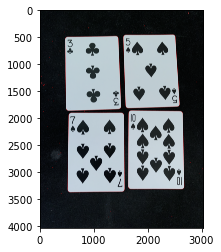

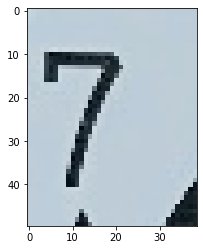

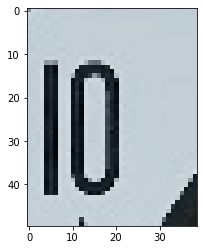

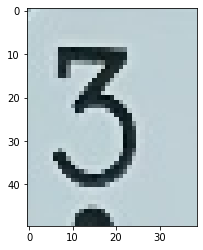

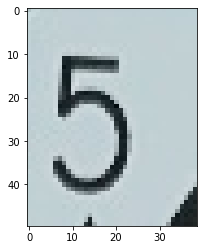

<Figure size 432x288 with 0 Axes>

In [134]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pytesseract


def warp_images():
    # convert the image to HSV color space
    img = cv2.imread('Card_Imgs/blackcards.jpg')
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)


    # find Otsu threshold on hue and saturation channel
    ret, thresh_H = cv2.threshold(img_hsv[:,:,0], 0, 0, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    ret, thresh_S = cv2.threshold(img_hsv[:,:,1], 0, 0, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    ret, thresh_V = cv2.threshold(img_hsv[:,:,2], 150, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # some morphology operation to clear unwanted spots
    kernel = np.ones((5, 5), np.uint8)
    thresh = thresh_H + thresh_S + thresh_V
   # print('Image shape',img_hsv.shape,'Thresh',thresh.shape,np.unique(thresh))
    img_dilated = cv2.dilate(thresh, kernel, iterations = 1)

    # find contours on the result above
    contours, hierarchy = cv2.findContours(img_dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    im1 = img.copy()
    for c in contours:
        cv2.drawContours(im1, contours=[c], contourIdx=-1, color=(255,0,0),thickness=2)
    plt.imshow(im1)
    plt.figure()

    # since there were few small contours found, retain only those above a certain area above 500 pixels
    im2 = img.copy()
    count = 0

    for c in contours:
        if cv2.contourArea(c) > 500000:
            count+=1
            cv2.drawContours(im2, [c], -1, (0, 255, 0), 10)
            #print(c.shape)
        
            peri = cv2.arcLength(c, True)
            approx = cv2.approxPolyDP(c, 0.015 * peri, True)
        
            if len(approx) == 4:
                screenCnt = approx
            
        
            pts = screenCnt.reshape(4, 2)
            rect = np.zeros((4, 2), dtype = "float32")
        
            s = pts.sum(axis = 1)
            rect[0] = pts[np.argmin(s)]
            rect[2] = pts[np.argmax(s)]
        
            diff = np.diff(pts, axis = 1)
            rect[1] = pts[np.argmin(diff)]
            rect[3] = pts[np.argmax(diff)]
            #print(rect)
            rect *= 1
            dst = np.array([[0, 0],[192, 0],[192, 300],[0, 300]], dtype = "float32")
            M = cv2.getPerspectiveTransform(rect, dst)
            warp = cv2.warpPerspective(img, M, (192, 300))
            #[top:bottom, left:right]
            warp = warp[0:50, 1:40]
            cv2.imwrite(f'Card_Imgs/cardthingy{count}.jpg', warp)
        
file_names = ['Ace','Jack', 'Queen', 'King', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Nine', 'Ten']

def read_images(*file_names):
    config = ('-l eng --oem 1 --psm 8')
    results = []
    for i in file_names:
        image = cv2.imread('Card_Imgs/'+i, cv2.IMREAD_COLOR)   # Read the image
        plt.imshow(image)   # Ploting the image using matplotlib
        plt.figure()
        image = imutils.resize(image, width=400)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
        # Blur and perform text extraction
        thresh = 255 - cv2.GaussianBlur(thresh, (5,5), 0)
        text = pytesseract.image_to_string(thresh, config=config)
        results.append(text)
    return results
        
warp_images()
results = read_images('cardthingy1.jpg', 'cardthingy2.jpg', 'cardthingy3.jpg', 'cardthingy4.jpg')
dealer = [results[0], results[1]]
player = [results[2], results[3]]
print(player)

